In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
image, label = training_data[0]  # 0th image

In [26]:
print(f"Length of the training dataset {len(training_data)}")
image.shape

Length of the training dataset 60000


torch.Size([1, 28, 28])

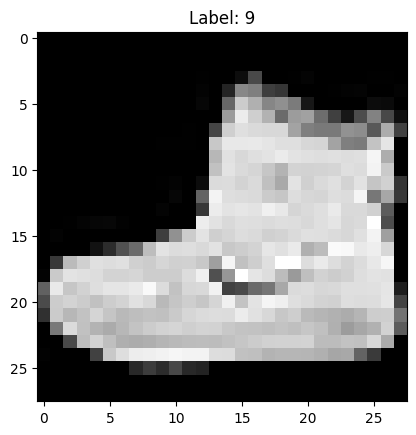

In [6]:
image_np = image.squeeze(dim=0).numpy()
plt.imshow(image_np, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

In [7]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [35]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(start_dim =1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        #print(f"Size of input Tensor {x.shape}")
        x = self.flatten(x)
        #print(f"After Flatten: {x.shape}")
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [37]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [38]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [39]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298296  [   64/60000]
loss: 2.282213  [ 6464/60000]
loss: 2.266148  [12864/60000]
loss: 2.263077  [19264/60000]
loss: 2.268831  [25664/60000]
loss: 2.225084  [32064/60000]
loss: 2.245842  [38464/60000]
loss: 2.199167  [44864/60000]
loss: 2.205921  [51264/60000]
loss: 2.186027  [57664/60000]
Test Error: 
 Accuracy: 36.4%, Avg loss: 2.163777 

Epoch 2
-------------------------------
loss: 2.181344  [   64/60000]
loss: 2.166702  [ 6464/60000]
loss: 2.114061  [12864/60000]
loss: 2.139325  [19264/60000]
loss: 2.099915  [25664/60000]
loss: 2.035254  [32064/60000]
loss: 2.087618  [38464/60000]
loss: 2.000578  [44864/60000]
loss: 2.002508  [51264/60000]
loss: 1.950973  [57664/60000]
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.915715 

Epoch 3
-------------------------------
loss: 1.960988  [   64/60000]
loss: 1.924359  [ 6464/60000]
loss: 1.854146  [12864/60000]
loss: 1.860061  [19264/60000]
loss: 1.766131  [25664/60000]
loss: 1.724658  [32064/600

In [27]:
torch.save(model.state_dict(), "model_01.pth")
print("Saved PyTorch Model State to model_01.pth")

Saved PyTorch Model State to model_01.pth


In [28]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model_01.pth", weights_only=True))

<All keys matched successfully>

In [29]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [30]:
my_req_dataset = next(iter(test_dataloader))

In [31]:
model.eval()
out = model(my_req_dataset[0].to(device))

In [32]:
out.shape

torch.Size([64, 10])

In [34]:
#torch.rand((64,1,28,28)).flatten(start_dim=1).shape